# Forecasting Air Quality in Beijing
Capstone Project for Springboard Data Science Bootcamp

Tamara Monge

## Section 3: Time Series Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/tami/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import cleaned dataset
df = pd.read_csv('persistence/cleaned_data_2018-06-19.csv', parse_dates=True, index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 7 columns):
pm25          41757 non-null float64
dewp          41757 non-null int64
temp          41757 non-null float64
pres          41757 non-null float64
wind_speed    41757 non-null float64
snow_hours    41757 non-null int64
rain_hours    41757 non-null int64
dtypes: float64(4), int64(3)
memory usage: 2.5 MB


##  Statistical Analysis

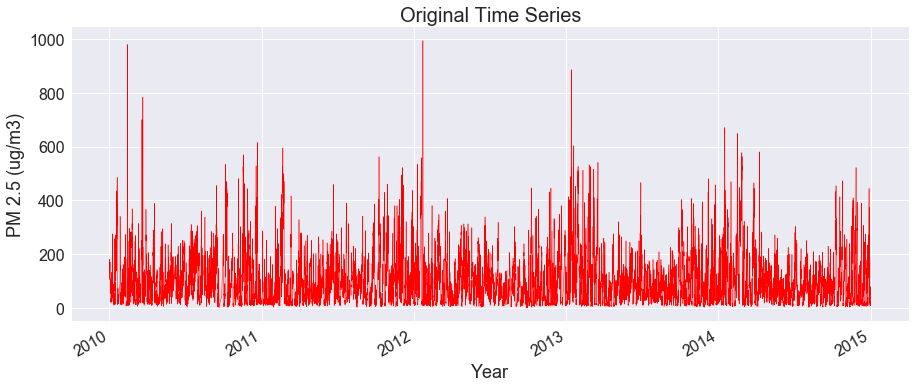

In [3]:
pm25 = df['pm25']

# Original time series
pm25.plot(figsize=(15,6), linewidth=0.5, fontsize=16, color='red')
plt.xlabel('Year', fontsize=18)
plt.ylabel('PM 2.5 (ug/m3)', fontsize=18)
plt.title('Original Time Series', fontsize=20);
plt.savefig('../figures/original_time_series.png');

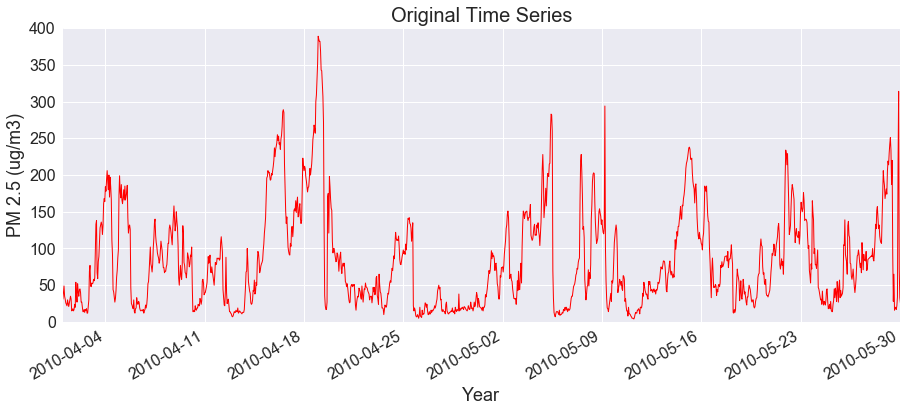

In [4]:
# Zoom in to look for structure on shorter timescale
pm25.plot(figsize=(15,6), linewidth=1, fontsize=16, color='red')
plt.xlabel('Year', fontsize=18)
plt.ylabel('PM 2.5 (ug/m3)', fontsize=18)
plt.title('Original Time Series', fontsize=20)
plt.xlim(['2010-04-01', '2010-05-30']);
plt.ylim([0,400])
plt.savefig('../figures/original_time_series_zoom.png');

#### 1. ACF and PACF 

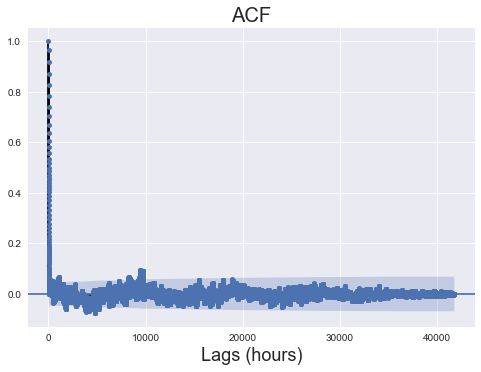

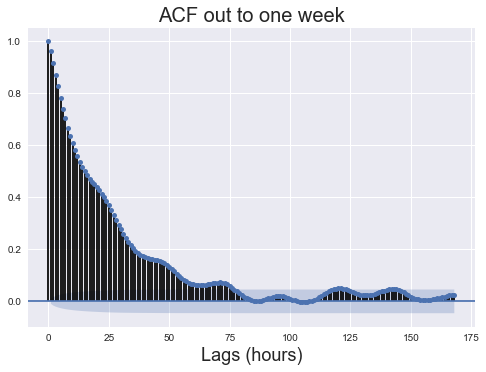

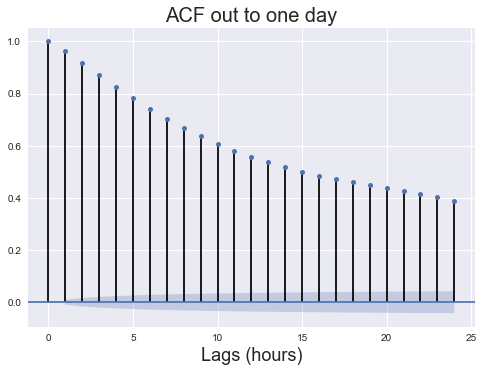

In [5]:
# Compute ACF of original time series
plt.figure(1)
plot_acf(pm25) 
plt.xlabel('Lags (hours)', fontsize=18)
plt.title('ACF', fontsize=20);

# Zoom in
plt.figure(2)
plot_acf(pm25, lags=168)  
plt.xlabel('Lags (hours)', fontsize=18)
plt.title('ACF out to one week', fontsize=20);
plt.savefig('../figures/acf_oneweek.png');

# Zoom in further
plt.figure(3)
plot_acf(pm25, lags=24)  
plt.xlabel('Lags (hours)', fontsize=18)
plt.title('ACF out to one day', fontsize=20);
plt.savefig('../figures/acf_oneday.png');

- The ACF decays gradually. 
- The ACF is significant out to lag-82.
- The ACF displays seasonality at two periods: lag-24 (1 day) and lag-8760 (1 year). 
- The ACF plot is positive at lag s=24, so we should consider adding an SAR term to the model. 

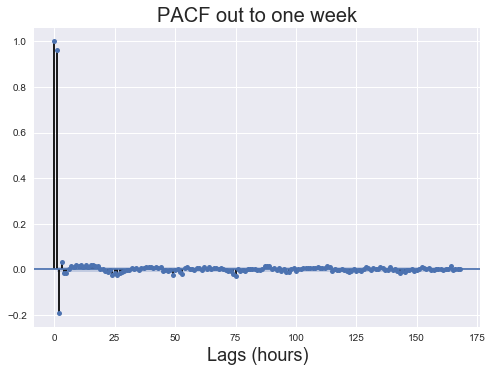

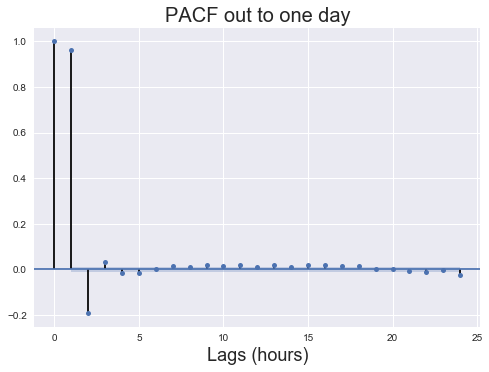

In [6]:
# Compute PACF of original time series
# Zoom in further
plt.figure(1)
plot_pacf(pm25, lags=168)  
plt.xlabel('Lags (hours)', fontsize=18)
plt.title('PACF out to one week', fontsize=20)
plt.savefig('../figures/pacf_oneweek.png');

# Zoom in further
plt.figure(2)
plot_pacf(pm25, lags=24)  
plt.xlabel('Lags (hours)', fontsize=18)
plt.title('PACF out to one day', fontsize=20)
plt.savefig('../figures/pacf_oneday.png');

- The PACF first crosses the significance line after lag-1. 
- No significant autocorrelation is explained by lags greater than 2.
- The PACF displays weak seasonality at lag-24 (1 day). 

#### 2. Decompose Structure

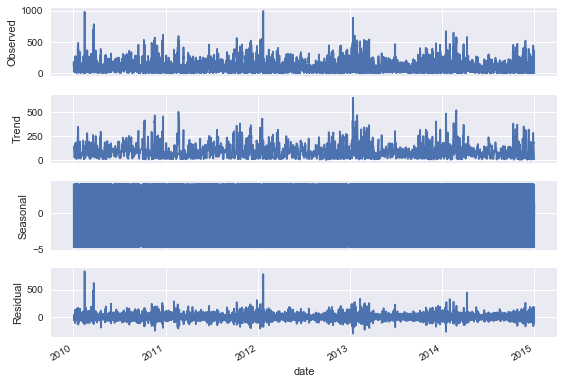

In [7]:
# Seasonal decomposition provided by statsmodels
decomposition = seasonal_decompose(pm25, model='additive', freq=24) # one day
decomposition.plot();
plt.savefig('../figures/seasonal_decomposition_daily.png');

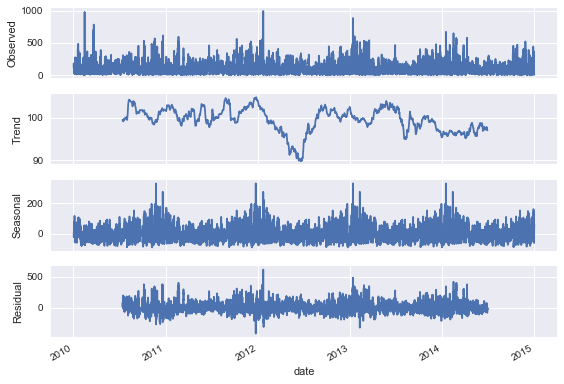

In [8]:
decomposition = seasonal_decompose(pm25, model='additive', freq=8760) # one year
decomposition.plot();
plt.savefig('../figures/seasonal_decomposition_yearly.png');

- Decomposition for a season of one-day, reveals little trend or seasonality.
- Decomposition for a season of one-year, reveals a pronounced trend and seasonality. 

#### 3. Test for Stationarity

Let's test for stationarity statistically using the Dickey-Fuller Test

In [9]:
# Perform Augmented Dickey Fuller test
from statsmodels.tsa.stattools import adfuller

test = adfuller(pm25, autolag='AIC')
print('Test Statistic:', test[0])
print('p-value:', test[1])
print('# Lags used:', test[2])
print('Number of observations used:', test[3])
print('Critical Values:', test[4])

Test Statistic: -20.6068246464
p-value: 0.0
# Lags used: 54
Number of observations used: 41702
Critical Values: {'1%': -3.4305068198783828, '5%': -2.8616093108616596, '10%': -2.5668068919322544}


- Test statistic is less than the 1% critical value, so we reject the null hypothesis of non-stationarity.
- The **`pm25` series is already stationary**, before applying the log and difference transformations.

Compute mean at a few different intervals as a sanity-check to confirm stationarity.

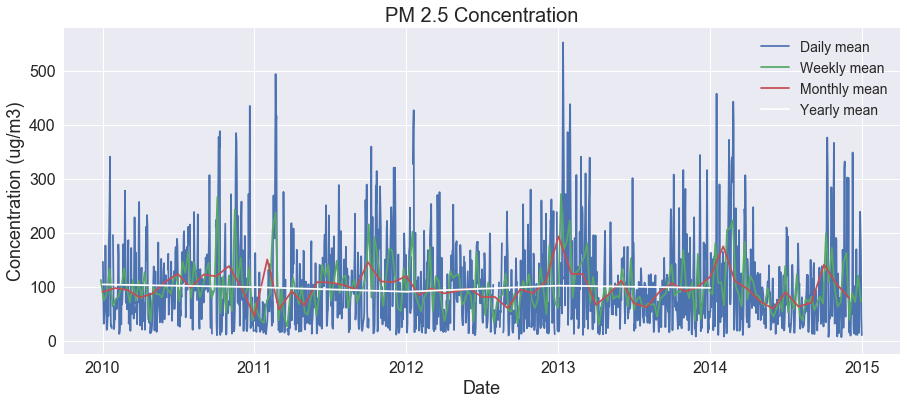

In [10]:
plt.figure(figsize=(15, 6))
df['pm25'].groupby(pd.Grouper(freq='D')).mean().plot(fontsize=16)
df['pm25'].groupby(pd.Grouper(freq='W')).mean().plot()
df['pm25'].groupby(pd.Grouper(freq='M')).mean().plot()
df['pm25'].groupby(pd.Grouper(freq='Y')).mean().plot(color='white')
plt.legend(['Daily mean', 'Weekly mean', 'Monthly mean', 'Yearly mean'], fontsize=14)
plt.title('PM 2.5 Concentration', fontsize=20)
plt.ylabel('Concentration (ug/m3)', fontsize=18)
plt.xlabel('Date', fontsize=18);
plt.savefig('../figures/stationary_series_check.png');

Does appear to conform to stationarity.

In [11]:
# #### 4. Look at the trend in more detail (MA)
# # Plot the moving average. This smooths out noise and seasonality and reveals trend.

# # Daily MA
# plt.figure(1)
# pm25.rolling(window=24).mean().plot(figsize=(20,10), linewidth=3, fontsize=20, color='red') 
# plt.xlabel('Year', fontsize=20)
# plt.title('Daily Moving Average (PM 2.5)', fontsize=24);
# plt.ylabel('PM 2.5 (ug/m3)', fontsize=20);
# #Daily moving average is still real noisy, let's see if expanding the window reveals a clearer trend

# # Weekly MA
# plt.figure(2)
# pm25.rolling(window=168).mean().plot(figsize=(20,10), linewidth=3, fontsize=20, color='red') 
# plt.xlabel('Year', fontsize=20)
# plt.title('Weekly Moving Average (PM 2.5)', fontsize=24);
# plt.ylabel('PM 2.5 (ug/m3)', fontsize=20);

# # Monthly MA
# plt.figure(3)
# pm25.rolling(window=720).mean().plot(figsize=(20,10), linewidth=3, fontsize=20, color='red') 
# plt.xlabel('Year', fontsize=20)
# plt.title('Monthly Moving Average (PM 2.5)', fontsize=24);
# plt.ylabel('PM 2.5 (ug/m3)', fontsize=20);

# # Yearly MA
# plt.figure(4)
# pm25.rolling(window=8760).mean().plot(figsize=(20,10), linewidth=3, fontsize=20, color='red')
# plt.xlabel('Year', fontsize=20)
# plt.title('Yearly Moving Average (PM 2.5)', fontsize=24);
# plt.ylabel('PM 2.5 (ug/m3)', fontsize=20);

# #- There is a fairly steady trend between early-2011 to mid-2012, a sharp decreasing trend into early-2013,
# # followed by a sharp increase into mid-2013, followed by a slowly decreasing trend into 2015.

In [12]:
# #### 5. Stationarize the series [Remove the trend (difference) and Stabilize the variance (log)]
# # First order difference stabilizes the mean (ie removes the trend)
# # Take the first-order difference
# df['first_difference'] = df['pm25'].diff()

# plt.figure(1)
# df['first_difference'].plot(figsize=(20,10), linewidth=3, fontsize=20)
# plt.xlabel('Year', fontsize=20)
# plt.title('First Order Difference', fontsize=20)
# plt.ylabel('PM 2.5 (ug/m3)', fontsize=20);
# # - First-order differencing seems to have done a decent job removing the trend; However, still have large differences in the variance above.


# # Take the log.
# df['log'] = df['pm25'].apply(lambda x: np.log(x))

# plt.figure(2)
# df['log'].plot(figsize=(20,10), linewidth=3, fontsize=20)
# plt.xlabel('Year', fontsize=20)
# plt.title('Log (Hourly PM2.5)', fontsize=20);
# # - Log transformation has made the varance relatively constant (at least of the same order of magnitude).


# # Combine the transformations: Take the first difference of the logged value
# df['log_first_difference'] = np.log(df['pm25']).diff().dropna()

# plt.figure(3)
# df['log_first_difference'].plot(figsize=(16,12))
# plt.xlabel('Year', fontsize=20)
# plt.title('Logged First-Order Difference', fontsize=20);
# # - We now have what appears to be a stationary time series model of the hourly `pm2.5` concentration.